In [1]:
from sklearn import datasets
from cachetools import cached
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from typing import Callable, Tuple
import matplotlib.pyplot as plt
import math

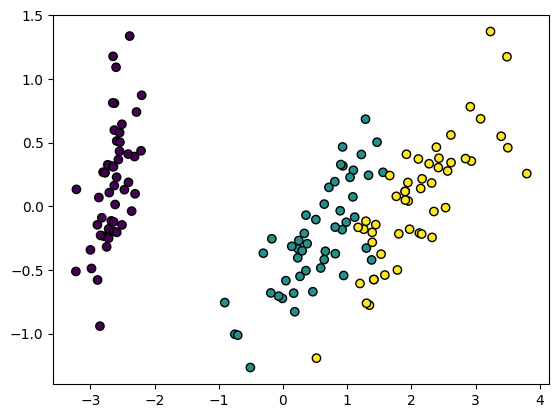

In [2]:
iris = datasets.load_iris()
Xorig = iris.data
y = iris.target
pca = PCA(n_components=2)
X = pca.fit(Xorig).transform(Xorig)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, edgecolor='k')

In [3]:
# Helper functions

def transpose(X):
    ans = []
    for i in range(len(X[0])):
        ans.append([])
        for j in range(len(X)):
            ans[-1].append(X[j][i])
    return ans
def adjugate(a, x, y):
    ans = []
    for i in range(len(a)):
        if i == x:
            continue 
        ans.append([])
        for j in range(len(a)):
            if j == y:
                continue 
            ans[-1].append(a[i][j])
    return ans

def det(X):
    if len(X) == 2:
        return X[0][0] * X[1][1] - X[0][1] * X[1][0]
    ans = 0
    for i in range(len(X)):
        num = det(adjugate(X, 0, i)) * X[0][i]
        if i % 2:
            ans -= num 
        else:
            ans += num
    return ans

def inv(X):
    if len(X) == 2:
        d = det(X)
        return [
            [ X[1][1] / d, -X[0][1] / d],
            [ -X[1][0] / d, X[0][0] / d],
        ]

    ans = []
    n = len(X)
    d = det(X)
    for i in range(n):
        ans.append([])
        for j in range(n):
            ans[-1].append((-1) ** (i + j) * det(adjugate(X, i, j)) / d )
    return transpose(ans)

def sub(x, y):
    ans = []
    n = len(x)
    m = len(x[0])
    for i in range(n):
        ans.append([])
        for j in range(m):
            ans[-1].append(x[i][j] - y[i][j])
    return ans
def mul(x, y):
    ans = []
    assert len(x[0]) == len(y)
    for i in range(len(x)):
        ans.append([])
        for j in range(len(y[0])):
            val = 0
            for w in range(len(y)):
                val += x[i][w] * y[w][j]
            ans[-1].append(val)
    return ans

def print_matrix(X):
    for i in range(len(X)):
        for j in range(len(X[i])):
            print(X[i][j] * 100 // 1 / 100, end = ' ')
        print()
A = [
    [1, 2, 3],
    [8, 9, 4],
    [7, 6, 5]
]
print("Transpose")
print_matrix(transpose(A))
print("Adjugate")
print_matrix(adjugate(A, 1, 1))
print("Determenant:")
print(det(A))
print("Inverse")
print_matrix(inv(A))
print("Mul")
print_matrix(mul(inv(A), A))

Transpose
1.0 8.0 7.0 
2.0 9.0 6.0 
3.0 4.0 5.0 
Adjugate
1.0 3.0 
7.0 5.0 
Determenant:
-48
Inverse
-0.44 -0.17 0.39 
0.25 0.33 -0.42 
0.31 -0.17 0.14 
Mul
0.99 0.0 0.0 
-0.01 1.0 -0.01 
0.0 0.0 1.0 


In [4]:
# Calculating mean matrix 
def get_mean_matrix(dist_x = None, dist_y = None):
    if dist_y is None:
        dist_y = y
    if dist_x is None:
        dist_x = X

    sums = {}
    counts = {}
    for i in range(len(dist_x)):
        x_class = dist_y[i]
        if x_class not in sums:
            sums[x_class] = [0, 0]
            counts[x_class] = 0
        sums[x_class][0] += dist_x[i, 0]
        sums[x_class][1] += dist_x[i, 1]
        counts[x_class] += 1
    average = [None] * 3
    for i in range(3):
        average[i] = (
            sums[i][0] / counts[i],
            sums[i][1] / counts[i]
        )
    return average
print_matrix(get_mean_matrix())

-2.65 0.19 
0.53 -0.25 
2.1 0.05 


In [5]:

def calc_covariance(x1, x2):
    n = len(x1)
    x1_mean = sum(x1) / n
    x2_mean = sum(x2) / n
    sumx = 0
    for i in range(n):
        sumx += (x1[i] - x1_mean) * (x2[i] - x2_mean)
    return sumx / n

def get_covariance_matrix(y_class, dist_x = None, dist_y= None):
    assert isinstance(y_class, int)
    if dist_x is None:
        dist_x = X
    if dist_y is None:
        dist_y = y

    distributions = [[], []]
    for i in range(len(dist_x)):
        if dist_y[i] != y_class:
            continue
        distributions[0].append(dist_x[i, 0])
        distributions[1].append(dist_x[i, 1])
    covariance_matrix = []
    for i in range(2):
        covariance_matrix.append([])
        for j in range(2):
            covariance_matrix[-1].append(
                calc_covariance(
                    distributions[i],
                      distributions[j]
                                ))
    return covariance_matrix
    

for i in range(3):
    cov = get_covariance_matrix(i)
    print_matrix(cov)
    print(det(cov))
    print_matrix(inv(cov))
    print("#" * 72)


0.04 0.05 
0.05 0.21 
0.007232926603251564
29.49 -7.6 
-7.6 6.64 
########################################################################
0.34 0.19 
0.19 0.18 
0.025282435268085532
7.17 -7.71 
-7.71 13.77 
########################################################################
0.48 0.27 
0.27 0.22 
0.038561900758508905
5.92 -7.02 
-7.02 12.66 
########################################################################


In [6]:
def calc_exp(x, mu, cov_inv):
    # (x - mu)^t cov_inv (x - mu)
    # 1*n, n*n n*1
    xp = [[x[i] - mu[i]] for i in range(len(x))]

    ans = mul(transpose(xp), cov_inv)
    ans = mul(ans, xp)
    assert len(ans) == 1
    assert len(ans[0]) == 1
    return math.e ** (-0.5 *  ans[0][0])

@cached({})
def get_discriminant_function(i: int, percent: float = 1, same_cov = False) -> Callable[Tuple[float, float], float]:

    perm = np.random.permutation(len(X))
    length = int(percent * len(X))

    dist_x = X[perm][:length]
    dist_y = y[perm][:length]
    mu_matrix = get_mean_matrix(dist_x, dist_y)[i]
    if same_cov:
        cov_matrix = get_covariance_matrix(0, dist_x, dist_y)
    
    else:
        cov_matrix = get_covariance_matrix(i, dist_x, dist_y)
    cov_det = det(cov_matrix)
    cov_inv = inv(cov_matrix)
    def inner(x1: float, x2: float):
        x = (x1, x2)
        ans = 1 / cov_det
        ans *= calc_exp(x, mu_matrix, cov_inv)
        return ans
    return inner
        

for i in range(3):
    func = get_discriminant_function(i)
    print(func(0, 0))

5.04343332083539e-45
3.4324768466638744
0.00010695704089471757


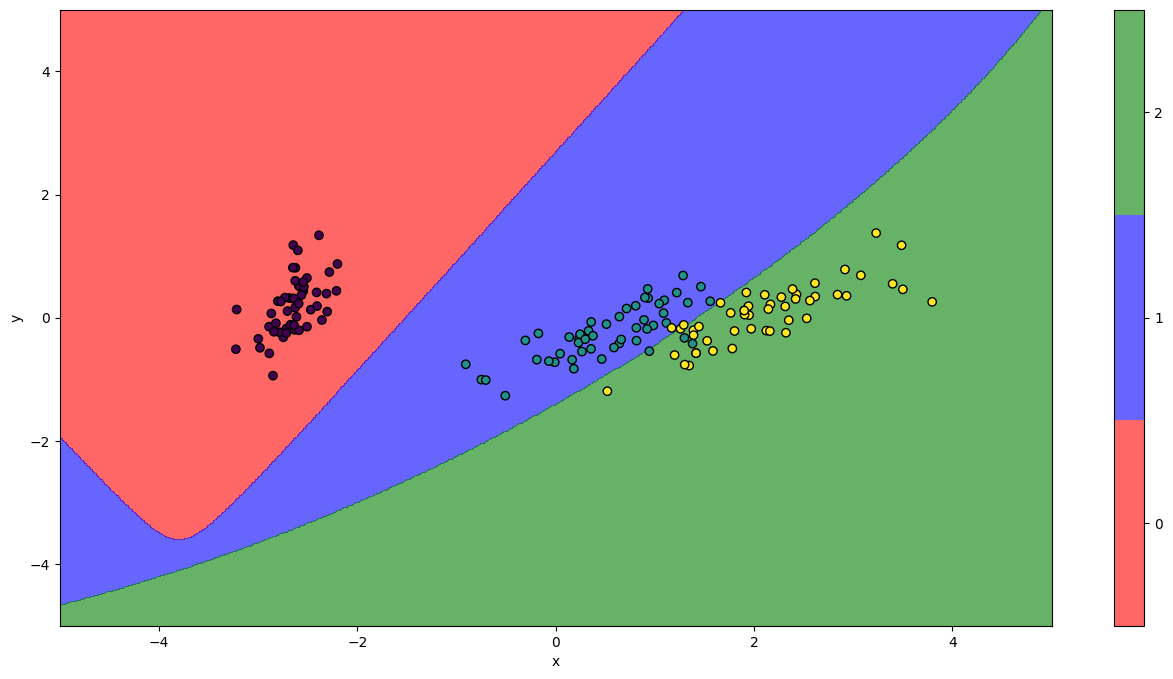

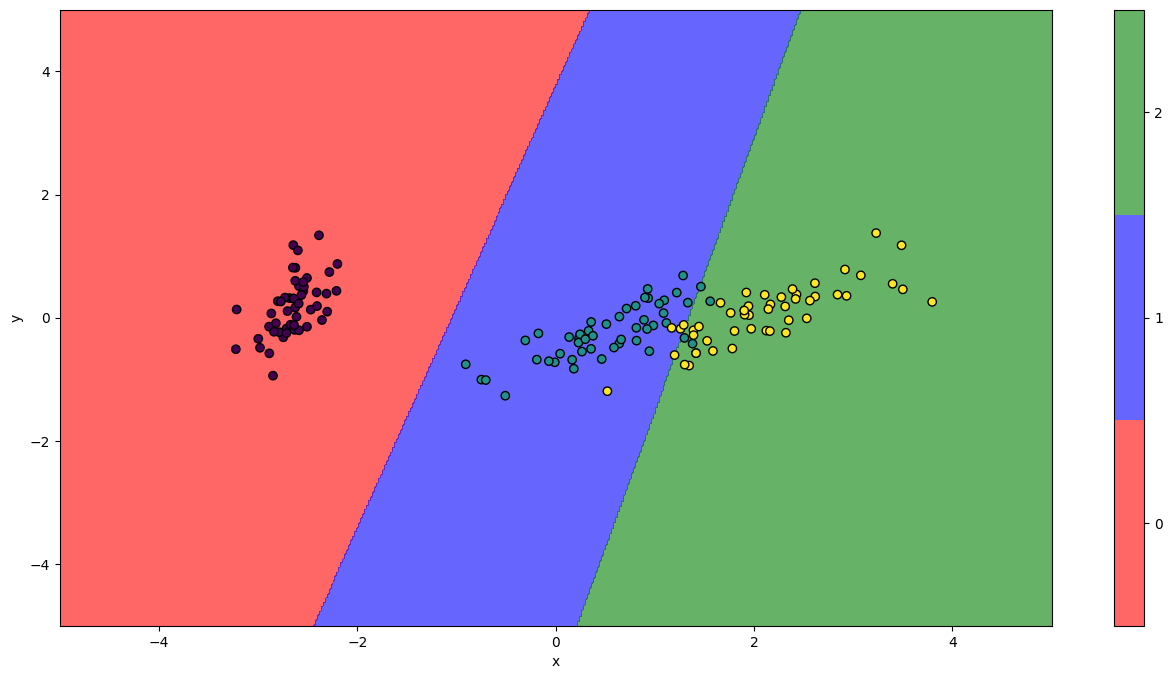

In [7]:

def plot_contours(discriminant1, discriminant2, discriminant3, reject_error = 1, line: Tuple[float, float, float] = None, show = True):
    """ 
   Line would be like a_1 x + a_2 y = a_3 
    """
    
    discriminant4 = lambda x, y: np.zeros(y.shape) + 1 - reject_error

    sample_x = np.linspace(-5, 5, 500)
    sample_y = np.linspace(-5, 5, 500)
    sample_x, sample_y = np.meshgrid(sample_x, sample_y)

    Z1 = discriminant1(sample_x, sample_y)
    Z2 = discriminant2(sample_x, sample_y)
    Z3 = discriminant3(sample_x, sample_y)
    Z4 = discriminant4(sample_x, sample_y)

    max_map = np.argmax(np.stack([Z1, Z2, Z3, Z4]), axis=0)


    if show:
        plt.figure(figsize=(16, 8))

    cmap = ListedColormap(['red', 'blue', 'green'])
    countour = plt.contourf(sample_x, sample_y, max_map, cmap=cmap, levels=[-0.5, 0.5, 1.5, 2.5], alpha=0.6)
    if show:
        plt.colorbar(countour, ticks=[0, 1, 2, 3])
    

    plt.xlabel('x')
    plt.ylabel('y')

    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, edgecolor='k')
    if line:
        first_point = (-6, (line[2] + 6 *line[0]) / line[1])
        second_point = (6, (line[2] - 6 *line[0]) / line[1])
        plt.axline(first_point, second_point, lw=5, c="black", ls="--")
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    if show:
        plt.show()
plot_contours(
    get_discriminant_function(0),
    get_discriminant_function(1),
    get_discriminant_function(2),
)

plot_contours(
    get_discriminant_function(0, same_cov=True),
    get_discriminant_function(1, same_cov=True),
    get_discriminant_function(2, same_cov=True),
)

In [8]:
m1 = [get_mean_matrix()[0]] # its actually mu transpose
m2 = [get_mean_matrix()[1]]
print_matrix(m1)
print("##############")
print_matrix(m2)
print("##############")
sigmai = inv(get_covariance_matrix(0))
print_matrix(sigmai)
print("###############")
print((mul(mul(m2, sigmai), transpose(m2))[0][0]  -  mul(mul(m1, sigmai), transpose(m1))[0][0]) / 2)
print("##############")
print_matrix(sub(mul(m2 , sigmai) , mul(m1, sigmai)))


-2.65 0.19 
##############
0.53 -0.25 
##############
29.49 -7.6 
-7.6 6.64 
###############
-101.53991897922246
##############
96.98 -27.02 


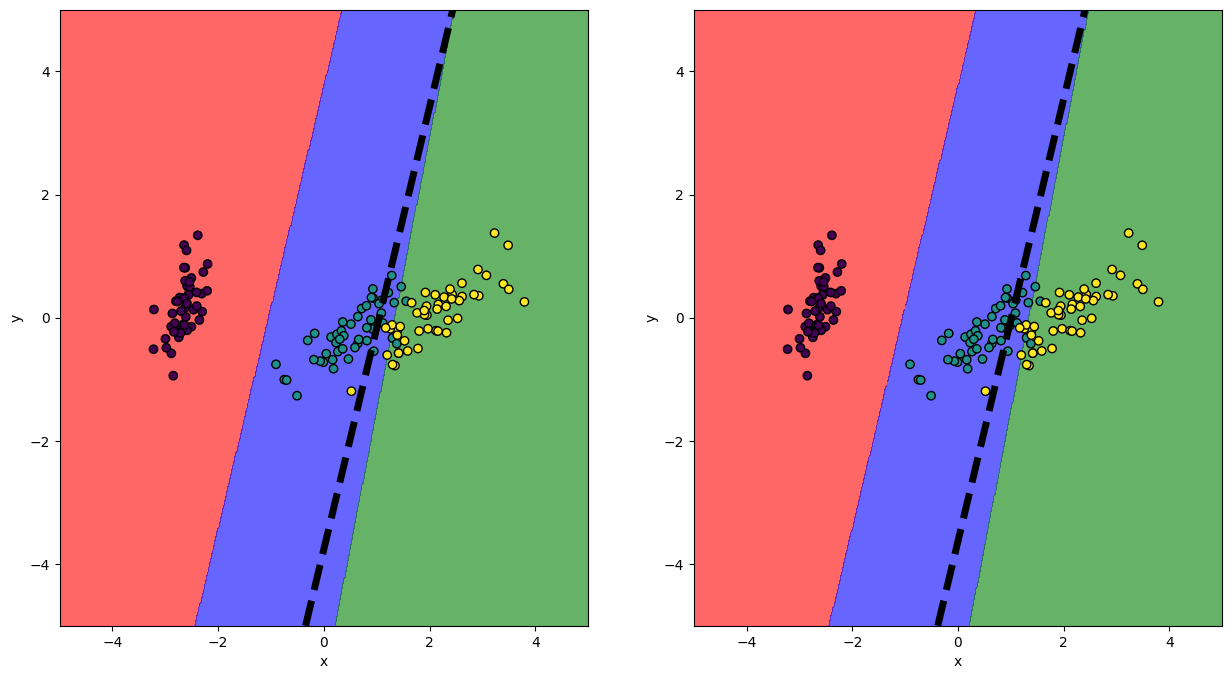

In [9]:

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plot_contours(
    get_discriminant_function(0, same_cov=True),
    get_discriminant_function(1, same_cov=True),
    get_discriminant_function(2, same_cov=True),
    line = (96.98, -27.02, 101.53),
    show = False
)
plt.subplot(1, 2, 2)
plot_contours(
    get_discriminant_function(0, same_cov=True),
    get_discriminant_function(1, same_cov=True),
    get_discriminant_function(2, same_cov=True),
    line = (96.98, -27.02, 98.07),
    show = False
)

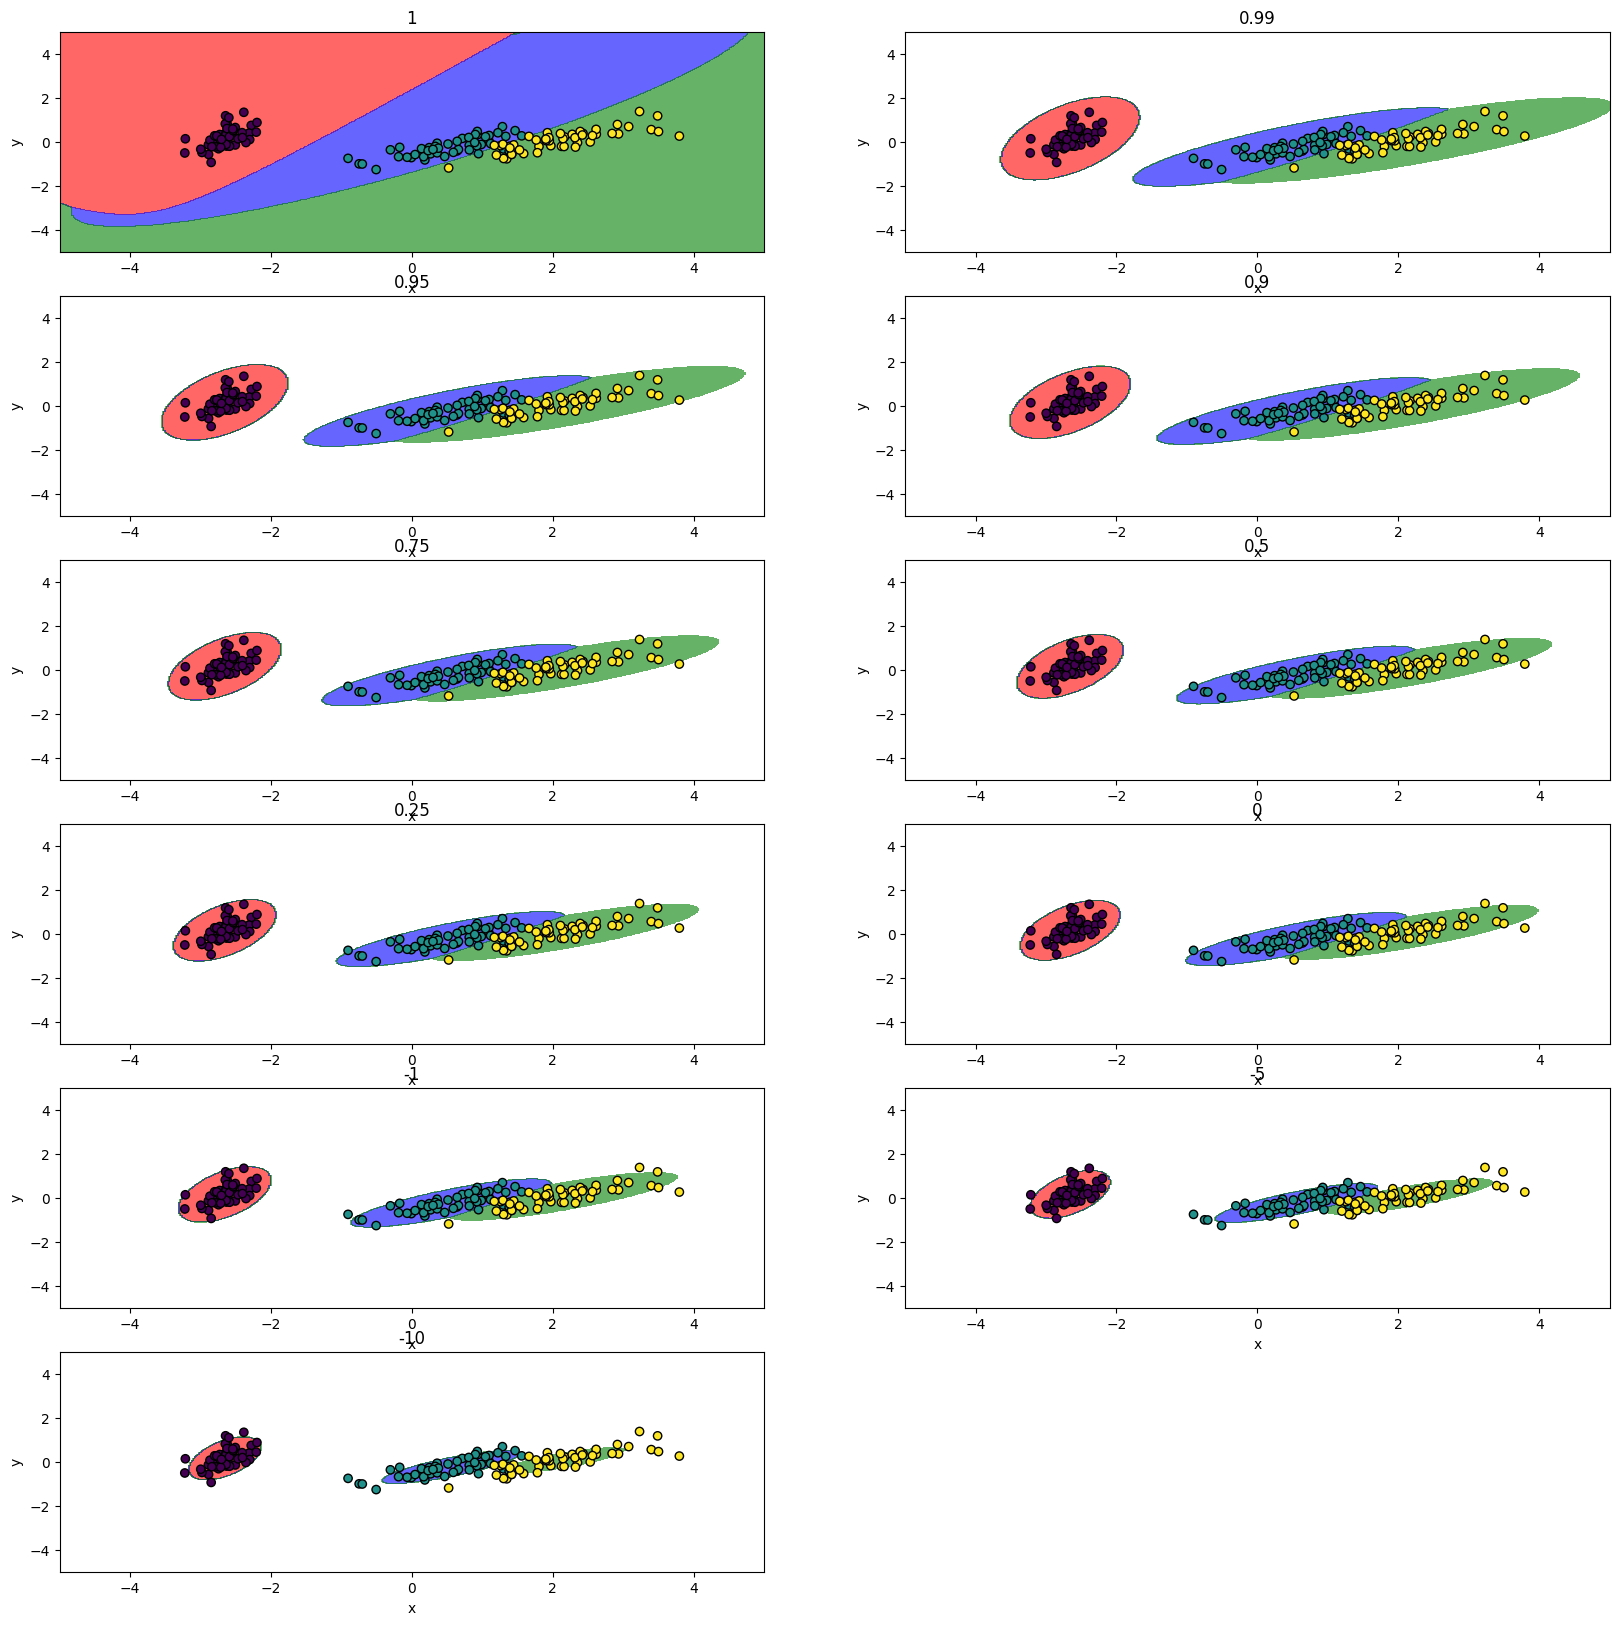

In [10]:
errors = (
    1,
    0.99,
    0.95,
    0.9,
    0.75,
    0.5,
    0.25,
    0,
    -1,
    -5,
    -10
)
cols = 2
plt.figure(figsize=(20, 20))
for i in range(len(errors)):
    plt.subplot(math.ceil(len(errors) / cols), cols, i + 1)
    plt.title(errors[i])
    # plt.axis('off')

    plot_contours(
    get_discriminant_function(0, percent = 0.8),
    get_discriminant_function(1, percent = 0.8),
    get_discriminant_function(2, percent = 0.8),
    reject_error=errors[i],
    show=False
    )